In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd

import sys

sys.path.append('T:\EL_experiment\Codes\CCEP_human\Python_Analysis/py_functions')

from scipy.stats import norm
from tkinter import *
import scipy
from scipy import signal

import platform
from glob import glob
from scipy.spatial import distance
import basic_func as bf
from scipy.integrate import simps
from numpy import trapz
import IO_func as IOF
import BM_func as BMf
import tqdm
from matplotlib.patches import Rectangle
from pathlib import Path
import LL_funcs as LLf
import freq_funcs as ff
#
from scipy.signal import hilbert, butter, filtfilt
import scipy.stats as stats
from tqdm.notebook import trange, tqdm
import significance_funcs as sig_func

dist_groups = np.array([[0, 30], [30, 60], [60, 120]])
dist_labels = ['local (<30 mm)', 'short (<60mm)', 'long']
Fs = 500
dur = np.zeros((1, 2), dtype=np.int32)
t0 = 1
dur[0, 0] = -t0
dur[0, 1] = 3

folder = 'BrainMapping'
# dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax = np.arange(dur[0, 0], dur[0, 1], (1 / Fs))
color_elab = np.zeros((3, 3))
color_elab[0, :] = np.array([31, 78, 121]) / 255
color_elab[1, :] = np.array([189, 215, 238]) / 255
color_elab[2, :] = np.array([0.256, 0.574, 0.431])
cwd = os.getcwd()

In [233]:
subj = 'EL016'
cond_folder = 'CR'  # Condition = 'Hour', 'Condition', 'Ph'

if cond_folder == 'Ph':
    cond_vals = np.arange(4)
    cond_labels = ['BM', 'BL', 'Fuma', 'BZD']
    cond_colors = ['#494159', '#594157', "#F1BF98", "#8FB996"]
    cond1 = 'Condition'  # 'condition', 'h'
    cond_folder = 'Ph'  # 'Ph', 'Sleep', 'CR'
    Condition = 'Condition'
if cond_folder == 'CR':
    Condition = 'Hour'  # Condition = 'Hour'
    cond1 = 'h'  # h (as stored in stimlist)

######## General Infos

path_patient_analysis = 'y:\\eLab\EvM\Projects\EL_experiment\Analysis\Patients\\' + subj
path_gen = os.path.join('y:\\eLab\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_patient, 'infos')
if not os.path.exists(path_infos):
    path_infos = path_gen + '\\infos'

sep = ';'
Fs = 500
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/BM_plot_trial').mkdir(parents=True, exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/single_con').mkdir(parents=True,
                                                                                              exist_ok=True)
Path(path_patient_analysis + '\\' + folder + '/' + cond_folder + '/figures/Pipeline').mkdir(parents=True, exist_ok=True)

# get labels
if cond_folder == 'Ph':
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*Ph*')
else:
    files_list = glob(path_patient_analysis + '\\' + folder + '/data/Stim_list_*')
i = 0
stimlist = pd.read_csv(files_list[i])
EEG_resp = np.load(path_patient_analysis + '\\' + folder + '/data/ALL_resps_'+files_list[i][-11:-4]+'.npy')
lbls = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
labels_all, labels_region, labels_clinic, coord_all, StimChans, StimChanSM, StimChansC, StimChanIx, stimlist = bf.get_Stim_chans(
    stimlist,
    lbls)

labels_h = lbls.Hemisphere + '_' + labels_all

badchans = pd.read_csv(path_patient_analysis + '\\' + folder + '/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:, 1] == 1))[0, :])

bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

file_con_all = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
file_con = path_patient_analysis + '\\' + folder + '/' + cond_folder + '/data/con_trial_all.csv'
######### Load data
rerun = 0
if os.path.isfile(file_con):
    # con_trial
    con_trial = pd.read_csv(file_con)

In [234]:
con_trial = pd.read_csv(file_con)

In [235]:
EEG_resp = np.load(path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\EEG_' + cond_folder + '.npy')
stimlist = pd.read_csv(
   path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\stimlist_' + cond_folder + '.csv')


In [236]:
Fs             = 500
dur            = np.zeros((1,2), dtype=np.int32)
t0 = 1
dur[0,0] =  -t0
dur[0,1] =  3

#dur[0,:]       = np.int32(np.sum(abs(dur)))
x_ax           = np.arange(dur[0,0],dur[0,1],(1/Fs))
color_elab      = np.zeros((3,3))
color_elab[0,:] = np.array([31, 78, 121])/255
color_elab[1,:] = np.array([189, 215, 238])/255
color_elab[2,:] = np.array([0.256, 0.574, 0.431])

## sleep

In [376]:
def plot_sig_trials():
    fig = plt.figure(figsize=(8, 8))
    fig.patch.set_facecolor('xkcd:white')
    sns.set(style='white')
    plt.title(labels_all[sc] + ' -- ' + labels_all[rc], fontsize=30)
    ylim = 300

        #fig.add_subplot(gs[0, sig])
    #gs = fig.add_gridspec(1,2)  # GridSpec(4,1, height_ratios=[1,2,1,2])
    for sig, sig_lab in zip([0,1,2],['Wake', 'NREM', 'REM']):
        stimnum = lists.loc[(lists.SleepState==sig_lab),'Num'].values.astype('int')
        #fig.add_subplot(gs[0, sig])
        # for i in range(len(stimnum)):
        #    plt.plot(x_ax, EEG_CR[rc, stimnum[i],:], color=color_elab[0], alpha=0.5)
        mn = np.mean(ff.lp_filter(EEG_resp[rc, stimnum,:],30,Fs),0)
        st= np.std(ff.lp_filter(EEG_resp[rc, stimnum,:],30,Fs),0)
        plt.plot(x_ax, mn, color=color_elab[sig], linewidth=5, alpha=0.7, label=sig_lab+', n: '+str(len(stimnum)))
        # st= np.std(ff.lp_filter(trials,30,Fs),0)
        # plt.fill_between(x_ax,mn-st, mn+st,color=color_elab[sig*2], alpha=0.2 )
    plt.xticks([-0.5, 0,0., 1], fontsize=20)
    plt.yticks([-400, 0, 400], fontsize=20)
    plt.xlabel('time [s]', fontsize=25)
    plt.ylabel('[uV]', fontsize=25)
    plt.legend( fontsize=20)
    plt.axvline(0, color=[0,0,0], label='stim')
        # plt.text(-0.3, 500, 'n: '+str(len(stimnum)), fontsize=20)
        #plt.title('Mean Across All Trials', fontsize=25)
    plt.xlim([-0.5, 1])
    plt.ylim([-ylim,ylim])
    plt.tight_layout()
    plt.savefig(path_patient_analysis + '\\' + folder + '\\'+cond_folder+'\\methods\\sleep_trials\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_SS.svg')
    # plt.savefig(path_patient_analysis + '\\' + folder + '\\'+cond_folder+'\\methods\\CC_surr_example\\'+subj+'_'+labels_all[sc]+'_'+labels_all[rc]+'_'+m+'.jpg')
    plt.axvspan(0,0.25, alpha=0.1)
    plt.show()

In [ ]:
[ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 19., 20., 21., 22., 23.,
       24., 25., 26., 27., 31., 32., 33., 34.]

In [363]:
np.unique(con_trial.loc[(con_trial.Sig==1)&(con_trial.Stim==4),'Chan'])

array([ 0.,  1.,  2.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 19., 20., 23., 26., 31., 32., 34., 36., 37., 39., 43.,
       46., 51., 52., 53., 54., 62., 64.])

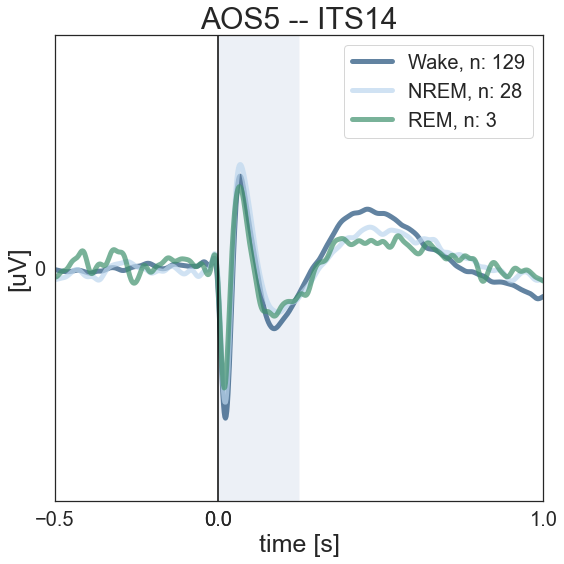

In [377]:
#k = np.random.choice(len(dat_plot),1)[0]
sc = 4
rc= 13
lists = con_trial[(con_trial['Artefact'] <1) & (con_trial['Chan'] == rc) & (con_trial['Stim'] == sc)]
plot_sig_trials()

In [6]:
def get_Stim_chans(stimlist, lbls):
    labels_all      = lbls.label.values
    labels_clinic   = lbls.Clinic.values
    labels_region   = lbls.Region.values
    coord_all       = np.array([lbls.x.values,lbls.y.values, lbls.z.values ]).T
    # get stimulation channels directly from stimlist
    StimChanSM = np.unique(stimlist.ChanP)

    ChanN = np.zeros((len(StimChanSM),))
    StimChans = []  # np.zeros((len(stim_chan)))
    StimChansC = []  # np.zeros((len(stim_chan)))
    StimChanIx = []  # np.zeros((len(stim_chan)))
    i = 0
    while i < len(StimChanSM):
        ChanN[i] = np.median(stimlist[stimlist.ChanP == StimChanSM[i]].ChanN)
        if ((np.array(lbls.ChanP_SM.values) == StimChanSM[i]) & (np.array(lbls.ChanN_SM.values) == ChanN[i])).any():
            # StimChans.append(labels_SM[(np.array(labels.chan_num.values)==stim_chan[i,0])][0])
            StimChans.append(labels_all[(np.array(lbls.ChanP_SM.values) == StimChanSM[i]) & (
                        np.array(lbls.ChanN_SM.values) == ChanN[i])][0])
            StimChansC.append(labels_clinic[(np.array(lbls.ChanP_SM.values) == StimChanSM[i]) & (
                        np.array(lbls.ChanN_SM.values) == ChanN[i])][0])
            StimChanIx.append(
                lbls[(np.array(lbls.ChanP_SM.values) == StimChanSM[i]) & (np.array(lbls.ChanN_SM.values) == ChanN[i])][
                    'Num'].values[0] - 1)
            i = i + 1
        else:
            StimChanSM = np.delete(StimChanSM, i, 0)

    stimlist = stimlist[np.isin(stimlist.ChanP, StimChanSM)]

    labels_region[labels_region == 'Temporal'] = 'Basotemporal'
    labels_region[labels_region == 'HIPP '] = 'Mesiotemporal'
    labels_region[labels_region == 'HIPP'] = 'Mesiotemporal'
    labels_region[labels_region == 'Temporal'] = 'Laterotemporal'

    return labels_all, labels_region,labels_clinic,coord_all,StimChans, StimChanSM,StimChansC, StimChanIx, stimlist

In [7]:
labels_all, labels_region,labels_clinic,coord_all,StimChans, StimChanSM,StimChansC, StimChanIx, stimlist = get_Stim_chans(stimlist, lbls)

In [10]:
con_trial = con_trial[~ np.isin(con_trial.Chan, bad_region)]
con_trial = con_trial[~ np.isin(con_trial.Stim, bad_region)]

In [37]:
data = con_trial[con_trial.Sig==1]
summ = data.groupby(['Stim','Chan'], as_index=False)[['Sig']].mean()

In [64]:
con_trial

,Chan,Stim,LL,P2P,Hour,Block,Sleep,Num,Num_block,Date,Artefact,d
0,0.0,0.0,374.056884,41553.469801,16.0,1.0,0.0,0.0,0.0,20230110.0,1.0,0.00
1,0.0,2.0,5.027295,458.754186,16.0,1.0,0.0,1.0,1.0,20230110.0,0.0,7.00
2,0.0,22.0,3.847557,193.526720,16.0,1.0,0.0,2.0,2.0,20230110.0,0.0,31.68
3,0.0,17.0,2.239015,243.150336,16.0,1.0,0.0,3.0,3.0,20230110.0,0.0,50.52
4,0.0,67.0,1.618899,159.649808,16.0,1.0,0.0,4.0,4.0,20230110.0,0.0,60.17
...,...,...,...,...,...,...,...,...,...,...,...,...
61093,105.0,9.0,3.543334,187.808446,17.0,2.0,0.0,594.0,594.0,20230110.0,0.0,101.23
61094,105.0,25.0,6.452914,557.469491,17.0,2.0,0.0,595.0,595.0,20230110.0,0.0,99.62
61095,105.0,12.0,6.055933,437.896591,17.0,2.0,0.0,596.0,596.0,20230110.0,0.0,107.90
61096,105.0,24.0,2.503184,181.357407,17.0,2.0,0.0,597.0,597.0,20230110.0,0.0,118.69


In [86]:
len(stimnum)

130

In [88]:
EEG_resp.shape

(106, 9391, 2000)

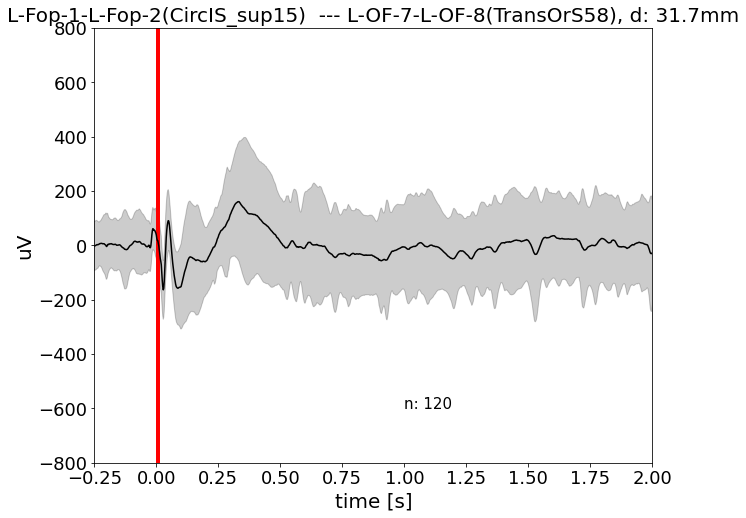

In [217]:
sc = 14
rc = 57

# sc_sel = 10
# sc = StimChanIx[sc_sel]
# sc_sm  = StimChanSM[sc_sel]
# stimnum = stimlist.loc[stimlist.ChanP==sc_sm, 'Num']
stimnum= con_trial.loc[(con_trial.Sleep==0)&(con_trial.Artefact==0)&(con_trial.Stim==sc)&(con_trial.Chan==rc),'Num'].values.astype('int')
d = np.round(scipy.spatial.distance.euclidean(coord_all[sc], coord_all[rc]),1)
plt.figure(figsize=(10,8))
plt.title(labels_clinic[sc]+'('+ labels_all[sc]+')  --- '+ labels_clinic[rc]+'('+ labels_all[rc]+'), d: '+str(d)+'mm', fontsize=20)
mn= np.mean(EEG_resp[rc,stimnum,:],0)
st = np.std(EEG_resp[rc,stimnum,:],0)
plt.plot(x_ax, mn, color=[0,0,0])
plt.fill_between(x_ax, mn-st, mn+st, alpha=0.2, color=[0,0,0])
plt.axvspan(0,0.01, color=[1,0,0])
plt.xlim([-0.25,2])
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('uV', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([-800,800])
plt.text(1, -600, 'n: '+str(len(stimnum)), fontsize=15)
#plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\EL018\BrainMapping\example\\'+labels_all[sc]+'_'+labels_all[rc]+'.jpg')
# plt.savefig('Y:\eLab\EvM\Projects\EL_experiment\Analysis\Patients\EL018\BrainMapping\example\\'+labels_all[sc]+'_'+labels_all[rc]+'.svg')
plt.show()


In [20]:
import significance_funcs as sf

0.0030000000000000027


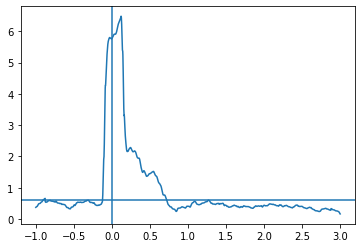

In [183]:
t_0 = 1
w = 0.25

data = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)]
stimnum = data.Num.values.astype('int')

resp = np.mean(EEG_resp[rc,stimnum,:],0)
resp = ff.lp_filter(resp, 45, Fs)
resp_LL = LLf.get_LL_all(np.expand_dims(resp,[0,1]), Fs, 0.25)[0][0]

plt.plot(x_ax,resp_LL)
thr = np.percentile(np.concatenate([resp_LL[int((w / 2) * Fs):int((t_0 - w / 2) * Fs)],
                                            resp_LL[int(3 * Fs):int((4 - w / 2) * Fs)]]),
                            99)  # LL_resp[0, 0, int((t_0+0.5) * Fs):] = 0 * Fs):] = 0
plt.axhline(thr)
LL_t = np.array(resp_LL[:int((t_0 + 0.5) * Fs)] > thr) * 1
t_resp_all = sf.search_sequence_numpy(LL_t, np.ones((int((w + 0.01) * Fs),)))
if len(t_resp_all) > 0:    
    t_onset = t_resp_all[0] / Fs - t_0 + w / 2
    r = 1
    print(t_onset)
    if (t_onset < 0.001) | (t_onset > 0.5):
        t_onset = 0
    plt.axvline(t_onset)

In [184]:
Fs

500

In [186]:
t_0 = 1
w = 0.25 
stimchans = np.unique(con_trial.Stim).astype('int')
M = np.zeros((len(labels_all),len(labels_all)))
for sc in stimchans:
    for rc in range(len(labels_all)):
        data = con_trial[(con_trial.Stim==sc)&(con_trial.Chan==rc)&(con_trial.Artefact<1)]
        stimnum = data.Num.values.astype('int')
        if len(stimnum)>0:
            resp = np.mean(EEG_resp[rc,stimnum,:],0)
            resp = ff.lp_filter(resp, 45, Fs)
            resp_LL = LLf.get_LL_all(np.expand_dims(resp,[0,1]), Fs, 0.25)[0][0]
            
            thr = np.percentile(np.concatenate([resp_LL[int((w / 2) * Fs):int((t_0 - w / 2) * Fs)],
                                            resp_LL[int(3 * Fs):int((4 - w / 2) * Fs)]]),
                            99)  # LL_resp[0, 0, int((t_0+0.5) * Fs):] = 0 * Fs):] = 0
            LL_t = np.array(resp_LL[:int((t_0 + 0.5) * Fs)] > thr) * 1
            t_resp_all = sf.search_sequence_numpy(LL_t, np.ones((int((w + 0.02) * Fs),)))

            if len(t_resp_all) > 0:
                M[sc,rc] = np.nanmax(resp_LL[500:750])
        else:
            M[sc,rc] = np.nan

In [25]:
regions       = np.unique(labels_region)
color_regions = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6',"#8FB996"]

#v= np.sort(labels_region)
#region_border = np.where(np.roll(v,1)!=v)[0]
#region_border = np.concatenate([region_border, [len(labels_all)]])
#region_num = np.diff(region_border)
#labels_sort     = labels_all[np.argsort(labels_region)]
#labels_region_sort = np.sort(labels_region)
#StimChanIx_sort = np.argsort(labels_region)

In [196]:
non_stim = np.arange(len(labels_all))
non_stim = np.delete(non_stim, StimChanIx, 0)
WM_chans = np.where(labels_region == 'WM')[0]
#WM_chans = np.where(labels_region == 'Unknown')[0]
bad_all = np.unique(np.concatenate([WM_chans, bad_region, bad_chans])).astype('int')
bad_all2 = np.unique(np.concatenate([WM_chans, bad_region, bad_chans, non_stim])).astype('int')

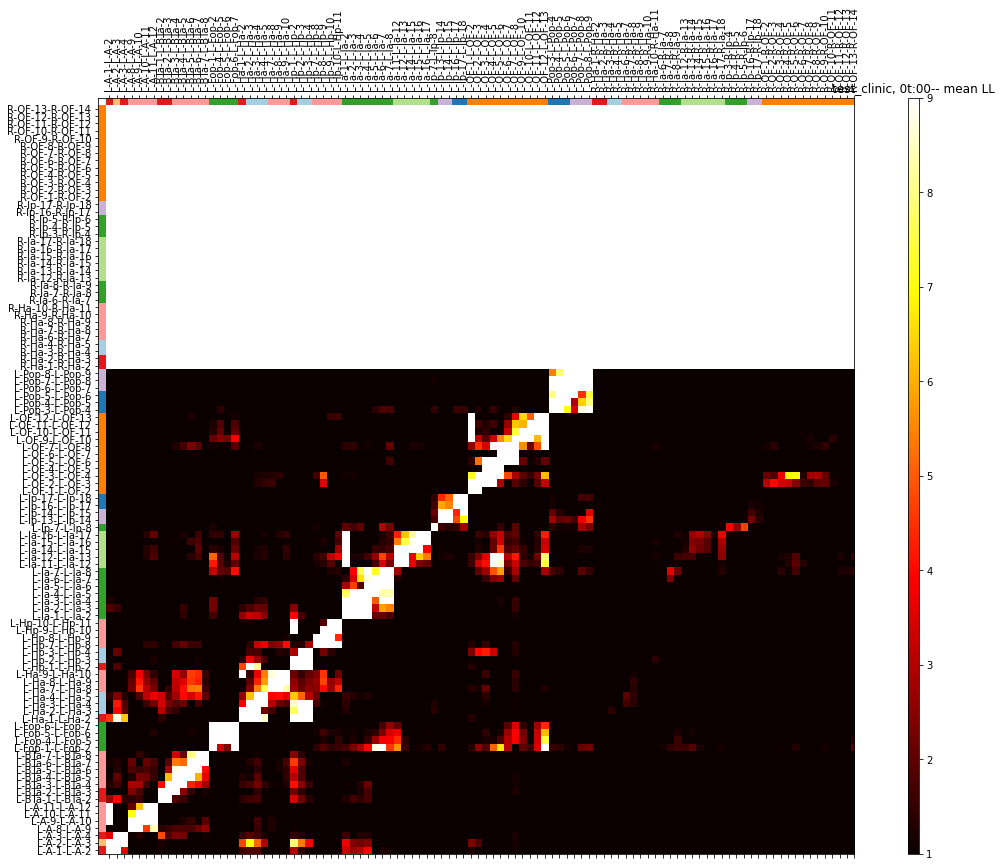

In [199]:
labels_sel   = np.delete(labels_clinic, bad_all, 0)
areas_sel    = np.delete(labels_region, bad_all, 0)
M_resp       = np.delete(np.delete(M, bad_all2, 0), bad_all, 1)

# # sort
# ind = np.argsort(areas_sel)
# M_resp= M_resp[ind,:]
# M_resp = M_resp[:,ind]
# labels_sel = labels_sel[ind]
# areas_sel = areas_sel[ind]
ll = 'test_clinic'
plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, 't')

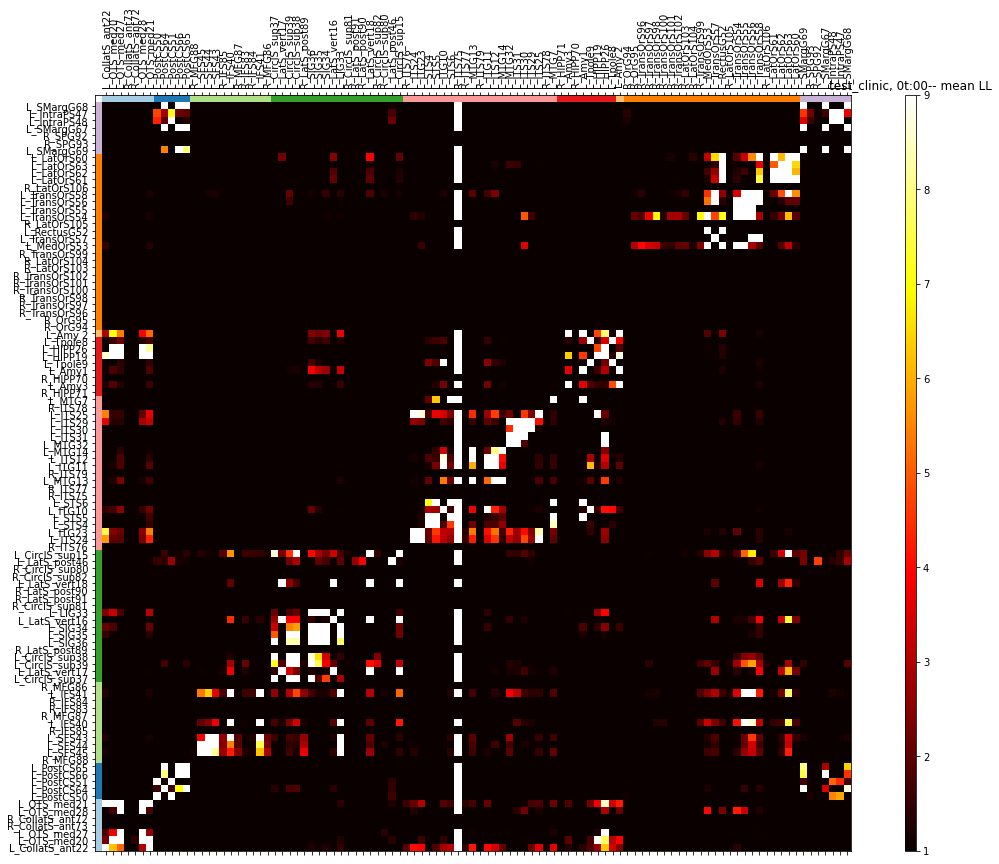

In [194]:
labels_sel   = np.delete(labels_h.values, bad_all, 0)
areas_sel    = np.delete(labels_region, bad_all, 0)
M_resp       = np.delete(np.delete(M, bad_all, 0), bad_all2, 1)

# sort
ind = np.argsort(areas_sel)
M_resp= M_resp[ind,:]
M_resp = M_resp[:,ind]
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]
ll = 'test_clinic'
plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, 't')

In [204]:
M[sc,rc]

nan

In [ ]:
sc = 2
rc = 48

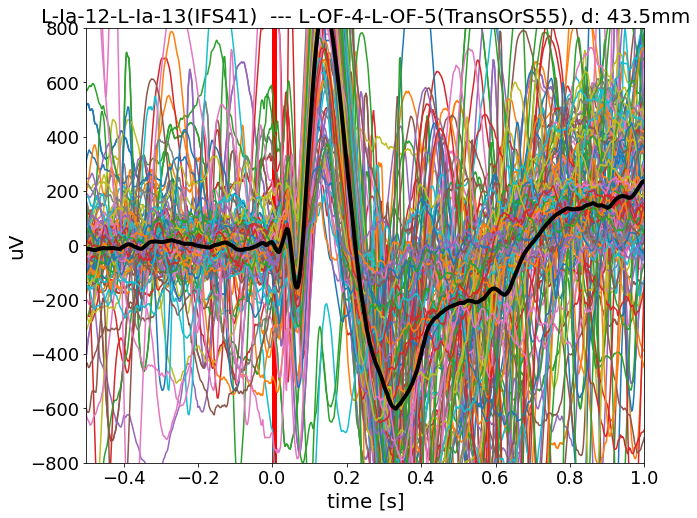

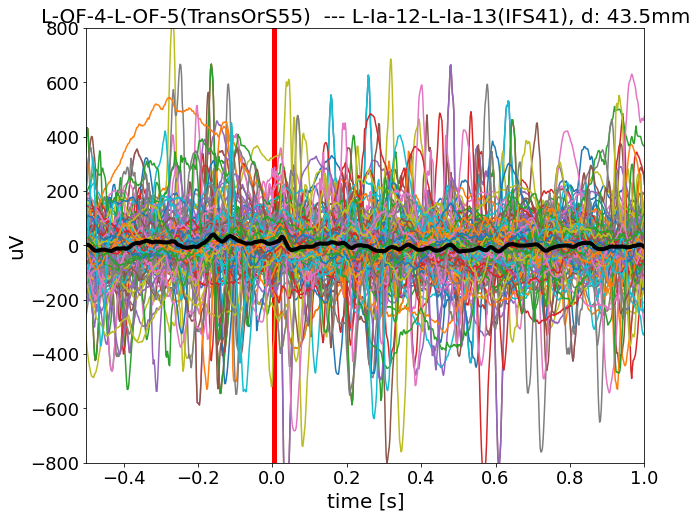

In [232]:
sc = 40
rc = 54
ylim = 800
# sc_sel = 10
# sc = StimChanIx[sc_sel]
# sc_sm  = StimChanSM[sc_sel]
# stimnum = stimlist.loc[stimlist.ChanP==sc_sm, 'Num']
stimnum= con_trial.loc[(con_trial.Stim==sc)&(con_trial.Chan==rc),'Num'].values.astype('int')
d = np.round(scipy.spatial.distance.euclidean(coord_all[sc], coord_all[rc]),1)
plt.figure(figsize=(10,8))
plt.title(labels_clinic[sc]+'('+ labels_all[sc]+')  --- '+ labels_clinic[rc]+'('+ labels_all[rc]+'), d: '+str(d)+'mm', fontsize=20)
mn= np.nanmean(EEG_resp[rc,stimnum,:],0)
#st = np.std(EEG_resp[rc,stimnum,:],0)
for i in range(len(stimnum)):
    plt.plot(x_ax, EEG_resp[rc,stimnum[i],:])
plt.plot(x_ax, mn, color=[0,0,0], linewidth=4)
#plt.fill_between(x_ax, mn-st, mn+st, alpha=0.2)
plt.axvspan(0,0.01, color=[1,0,0])
plt.xlim([-0.5,1])
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('uV', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([-ylim,ylim])
plt.show()

stimnum= con_trial.loc[(con_trial.Stim==rc)&(con_trial.Chan==sc),'Num'].values.astype('int')
d = np.round(scipy.spatial.distance.euclidean(coord_all[sc], coord_all[rc]),1)
plt.figure(figsize=(10,8))
plt.title(labels_clinic[rc]+'('+ labels_all[rc]+')  --- '+ labels_clinic[sc]+'('+ labels_all[sc]+'), d: '+str(d)+'mm', fontsize=20)
mn= np.nanmean(EEG_resp[sc,stimnum,:],0)
#st = np.std(EEG_resp[rc,stimnum,:],0)
for i in range(len(stimnum)):
    plt.plot(x_ax, EEG_resp[sc,stimnum[i],:])
plt.plot(x_ax, mn, color=[0,0,0], linewidth=4)
#plt.fill_between(x_ax, mn-st, mn+st, alpha=0.2)
plt.axvspan(0,0.01, color=[1,0,0])
plt.xlim([-0.5,1])
plt.xlabel('time [s]', fontsize=20)
plt.ylabel('uV', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([-ylim,ylim])
plt.show()


## First versions

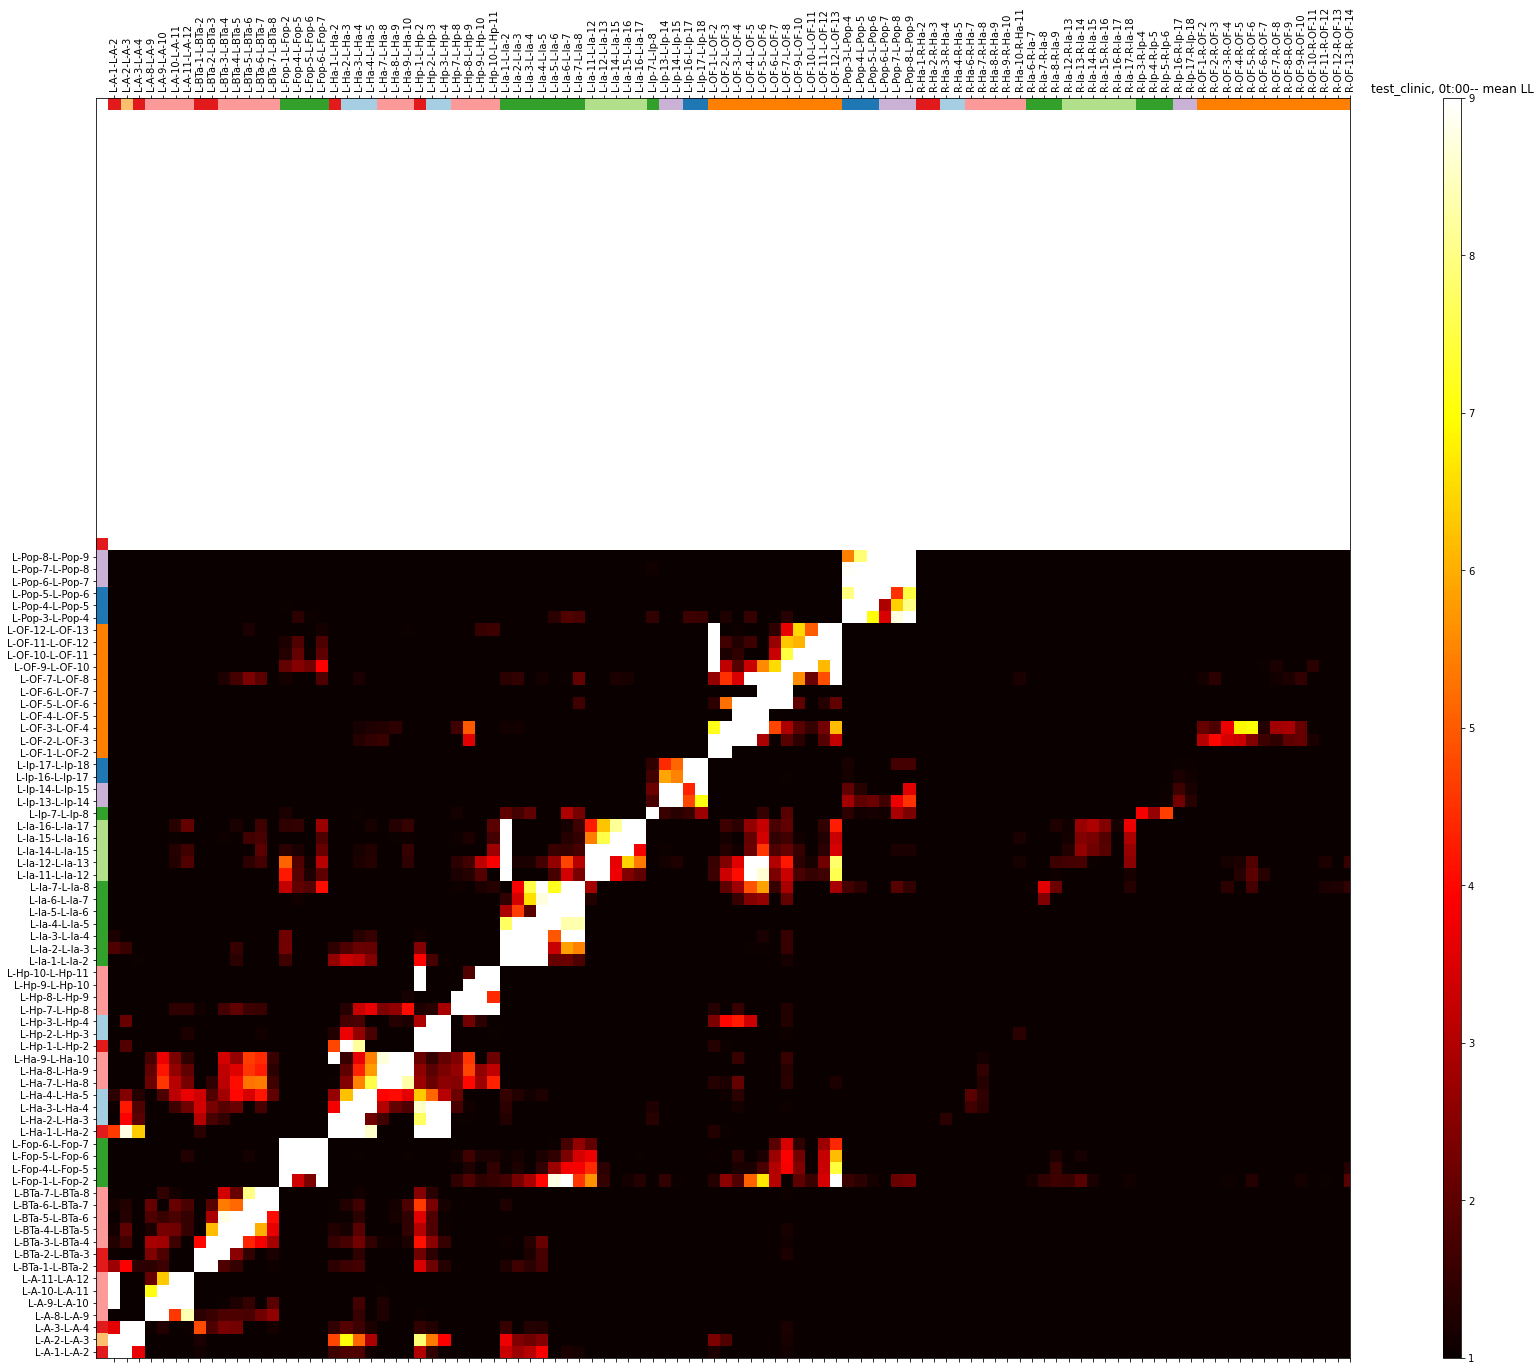

In [211]:
plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, 't')

In [205]:
M_resp.shape

(66, 102)

In [210]:
def plot_BM_CR_trial_sig(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(25,25))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, origin='lower',cmap='hot', vmin=1, vmax= 9)
    plt.xlim([-1.5, M.shape[0]-0.5])
    plt.ylim([-0.5, M.shape[1]+0.5])
    plt.xticks(range(M.shape[1]), labels[:M.shape[1]], rotation=90);
    plt.yticks(range(M.shape[0]), labels[:M.shape[0]]);
    for i in range(len(labels)):
        r         = areas[i]
        if i <=M.shape[1]:
            axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        if i <=M.shape[0]:
            axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    #axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    #circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    #plt.text(0.3,0.3, time)
    #plt.axis('off')
    #axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- mean LL')
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    #Path(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/').mkdir(parents=True, exist_ok=True)
    #plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/BM_'+label+'.jpg')
    #plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/BM_'+label+'.jpg')
    #plt.close(fig) #plt.show()#
    


In [5]:
file_con = path_patient_analysis + '\\' + folder + '\\' + cond_folder + '\\data\\con_trial_all.csv'
con_trial    = pd.read_csv(file_con)

(-500.0, 500.0)

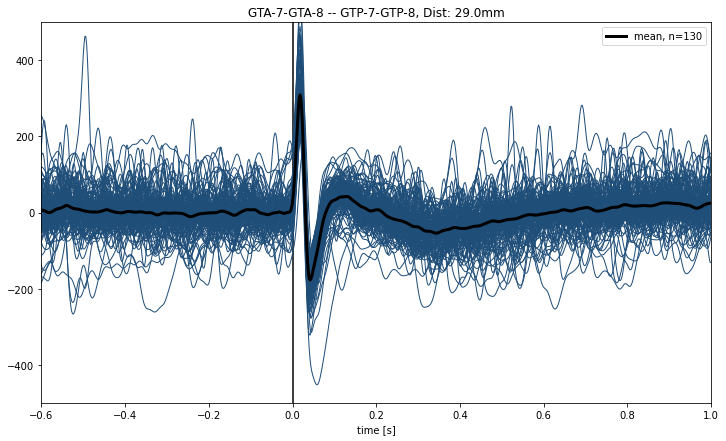

In [75]:
sc  =6
rc = 62#rc+1
plot_mean(sc, rc, con_trial[con_trial.Artefact==0],EEG_resp, labels_clinic)
plt.ylim([-500,500])

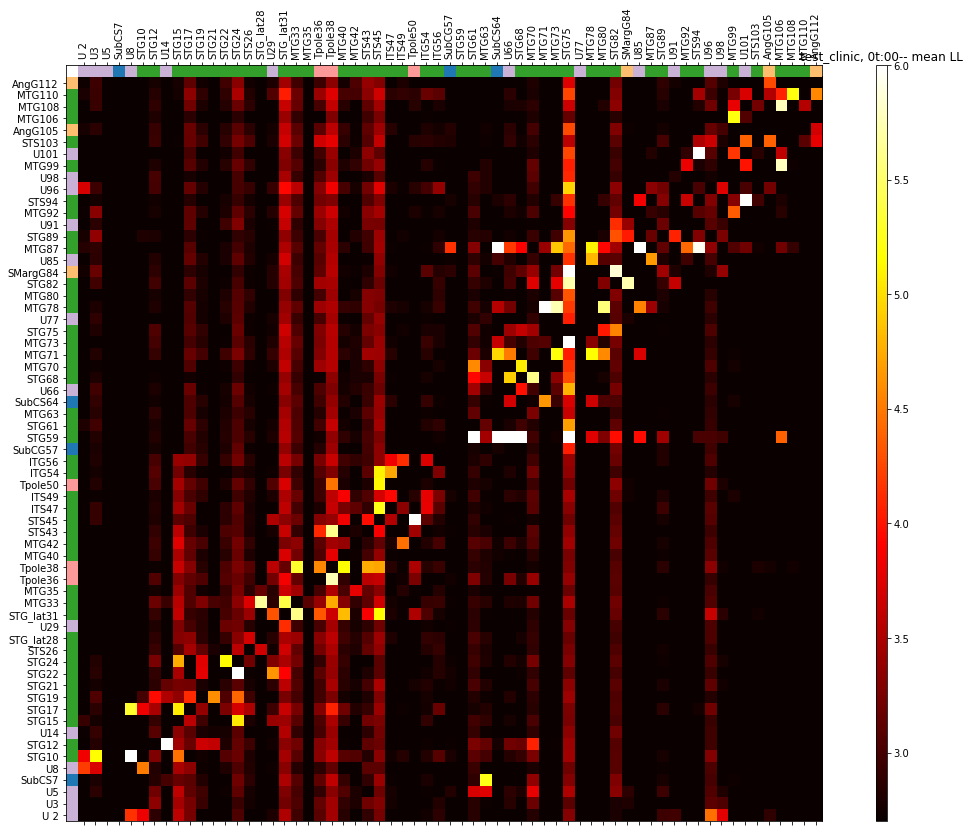

In [71]:
#b =1
y = 'LL'
summ = con_trial[(con_trial.Artefact==0)&(con_trial.LL>0)]
summ = summ.groupby(['Stim', 'Chan'], as_index=False)[y].mean()#summ[summ.Sig_block>3]
#t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
M = np.zeros((len(labels_all),len(labels_all)))
for sc in np.unique(summ.Stim).astype('int'):
    chan = summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
    LL   = summ.loc[summ.Stim==sc, y].values
    M[sc,chan] = LL
M = np.nan_to_num(M)
# BM plot
labels_sel   = np.delete(labels_all, bad_all, 0)
areas_sel    = np.delete(labels_region, bad_all, 0)
M_resp       = np.delete(np.delete(M, bad_all, 0), bad_all, 1)

# sort
#ind = np.argsort(areas_sel)
#M_resp= M_resp[ind,:]
#M_resp = M_resp[:,ind]
#labels_sel = labels_sel[ind]
#areas_sel = areas_sel[ind]
ll = 'test_clinic'
plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, 't')
#i = i+1

In [89]:
import LL_funcs as LLf

In [72]:
cond_folder ='CR'

In [73]:

file = path_analysis+'\\BrainMapping\\' + cond_folder + '\\data\\con_trial_all.csv'
con_trial.to_csv(file, index=False, header=True)

In [41]:
EEG_resp.shape

(118, 591, 2000)

In [42]:
con_trial

,Chan,Stim,LL,P2P,Hour,Block,Sleep,Num,Num_block,Date,Artefact,d
0,0.0,53.0,13.600699,1222.310887,17.0,1.0,0.0,0.0,0.0,20221129.0,1.0,39.23
1,0.0,23.0,3.493237,353.564406,17.0,1.0,0.0,1.0,1.0,20221129.0,1.0,18.31
2,0.0,4.0,5.052191,458.545182,17.0,1.0,0.0,2.0,2.0,20221129.0,1.0,19.55
3,0.0,30.0,2.082124,176.506516,17.0,1.0,0.0,3.0,3.0,20221129.0,1.0,22.48
4,0.0,2.0,4.887138,435.692491,17.0,1.0,0.0,4.0,4.0,20221129.0,1.0,9.46
...,...,...,...,...,...,...,...,...,...,...,...,...
984587,117.0,11.0,1.136974,67.671726,9.0,17.0,0.0,8339.0,204.0,20221130.0,0.0,60.05
984588,117.0,30.0,2.532126,124.353613,9.0,17.0,0.0,8340.0,205.0,20221130.0,0.0,55.59
984589,117.0,9.0,1.476809,78.421989,9.0,17.0,0.0,8341.0,206.0,20221130.0,0.0,63.91
984590,117.0,86.0,1.741379,101.524462,9.0,17.0,0.0,8342.0,207.0,20221130.0,0.0,37.11


In [39]:
sc  = 10
rc = 3#rc+1
plot_mean(sc, rc, con_trial,EEG_resp, labels_clinic)

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 864x504 with 0 Axes>

In [50]:
non_stim = np.arange(len(labels_all))
non_stim = np.delete(non_stim, StimChanIx, 0)
bad_all = np.unique(np.concatenate([bad_region, bad_chans, non_stim])).astype('int')

In [ ]:
block_l = file[-11:-4]
file = path_patient + '/Analysis/BrainMapping/' + cond_folder + '/data/con_trial_' + block_l + '.csv'
con_trial.to_csv(file, index=False, header=True)

In [146]:
chan, trial = np.where(np.max(abs(EEG_resp[:, :, int(0.98 * Fs):int(1.008 * Fs)]), 2) > 2000)
for i in range(len(trial)):
    con_trial.loc[
        (con_trial.Chan == chan[i]) & (con_trial.Num_block == trial[i]), 'LL'] = np.nan
con_trial.loc[(con_trial.LL > 40), 'LL'] = np.nan
con_trial = con_trial[~ np.isin(con_trial.Chan, bad_region)]
con_trial = con_trial[~ np.isin(con_trial.Stim, bad_region)]

In [69]:
def plot_BM_CR_trial_sig(M, labels,areas, label, t):
    time        = str(t).zfill(2)+':00'
    fig      = plt.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=2.7, vmax= 6)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    for i in range(len(labels)):
        r         = areas[i]
        axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
        axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    #axcolor = fig.add_axes([0.04,0.85,0.08,0.08]) # x, y, x_len, y_len
    #circle1 = plt.Circle((0.5,0.5), 0.4, color = CR_color[t], alpha = CR_color_a[t])
    #plt.text(0.3,0.3, time)
    #plt.axis('off')
    #axcolor.add_patch(circle1)
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(label+', '+time+ '-- mean LL')
    #plt.savefig(path_patient + '/Analysis/BrainMapping/CR/figures/BM_plot/BM_'+label+'.svg')
    #Path(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/').mkdir(parents=True, exist_ok=True)
    #plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/BM_'+label+'.jpg')
    #plt.savefig(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/figures/BM_plot_trial_sig/GIF/BM_'+label+'.jpg')
    #plt.close(fig) #plt.show()#
    


In [53]:
def plot_mean(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.LL.values))]
    
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 200

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1)
    resp_all = ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)
    # w_LL =0.1
    # resp_LL = LLf.get_LL_all(np.expand_dims(np.expand_dims(resp_all,0),0), 500, w_LL, 1, 0)
    # resp_LL =resp_LL[0,0,:]
    # start_resp = np.argmax(resp_LL[int(t0*Fs):int((t0+0.5)*Fs)])/Fs-w_LL/2+0.01
    #print(start_resp)
    plt.plot(x_ax,resp_all, c=[0,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    #plt.plot(x_ax,resp_LL*100, c=[1,0,0], linewidth=3, label='LL')
    ## finding peaks
    t_0=1
    resp_z = ff.lp_filter(np.mean(bf.zscore_CCEP(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs)),0),45,Fs)
    # #std_z = np.std(bf.zscore_CCEP(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs)),0)
    # # plt.plot(x_ax,resp_z*100, c=[1,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    # #start_resp = 0
    # #print(np.max(abs(resp_z[int(1.01*Fs):int(1.3*Fs)])))
    # if np.max(abs(resp_z[int(1.01*Fs):int(1.3*Fs)])) > 2.5:
    #     ## get start resp
    #     
    #     # peaks_p, properties_all = scipy.signal.find_peaks(
    #     #     (resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=0.5, prominence=1,
    #     #     distance=0.01 * Fs, width=1)  #
    #     # peaks_n, properties_all = scipy.signal.find_peaks(
    #     #     -(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=0.5, prominence=1,
    #     #     distance=0.01 * Fs, width=1)  #
    #     # print(np.concatenate([peaks_p, peaks_n]))
    #     # if (len(peaks_p)+len(peaks_n))>0:
    #     #     #print(np.concatenate([peaks_p, peaks_n]))
    #     #     peaks_all =min(np.concatenate([peaks_p, peaks_n]))
    #     #     #w = scipy.signal.peak_widths(abs(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), [peaks_all],rel_height=0.2)[0]
    #     #     
    #     #     start_resp = (peaks_all) / Fs - 0.02# (peaks_all - w) / Fs - 0.01
    #     if start_resp < 0.01:
    #         start_resp = 0
# 
    #     pk, peak_s, p = get_peaks_all(resp_z,start_resp)
    # 
    #     plt.plot(peak_s, resp_all[pk.astype('int')], "^", color= [1,0,0])
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([ylim*1.071,300]),np.max([ylim*1.071,300])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(start_resp+0.01,start_resp+0.05, alpha=0.8, color=color_elab[1])
    #plt.axvspan(start_resp+0.08, start_resp+0.4, alpha=0.8, color=color_elab[1])
    plt.legend()
    #plt.show()

In [ ]:
c = 3
fig = plt.figure(figsize=(15,5))
plt.plot(x_ax, EEG_resp[c,103,:],linewidth=7, color=color_elab[0])
plt.xticks([-0.5, 0, 0.5])
plt.axvline(-0.01, linewidth=5, color=[1,0,0])
plt.axvspan(0.01, 0.04, alpha=0.1)
plt.axvspan(0.08, 0.25, alpha=0.1)
plt.xlim([-0.5, 1])
plt.axis('off')

fig = plt.figure(figsize=(10,30))
n = 6
e = 9
stimNum = 555
gs       = fig.add_gridspec(7,1)
for i in range(n):
    fig.add_subplot(gs[i,0])
    
    plt.xticks([])
    plt.xlim([-1, 1.5])

    plt.ylim([-600,600])
    plt.plot(x_ax, EEG_resp[i+e,stimNum,:],linewidth=10, color=color_elab[0])
    
    plt.axvline(0, linewidth=5, color=[1,0,0])
    plt.axis('off')

plt.xticks([-1, 0, 1])
fig.tight_layout() 

plt.show()

In [ ]:
## load
if cc==1:
    EEG_resp = np.load(path_patient + '/Analysis/BrainMapping/data/All_resps_all.npy')

else:
    EEG_resp = np.load(path_patient + '/Analysis/BrainMapping/data/All_resps_'+file[-11:-4]+'.npy')
stimlist = pd.read_csv(file)
stimlist.StimNum = np.arange(len(stimlist))
stimlist = stimlist[(stimlist.condition==0)&(stimlist.currentflow==100)]
print('data loaded with '+str(EEG_resp.shape[1])+' stimulations')
print(EEG_resp.shape)

if os.path.isfile(path_patient + '/Analysis/BrainMapping/data/badchan.csv'):
    badchans  = pd.read_csv(path_patient + '/Analysis/BrainMapping/data/badchan.csv')
    bad_chans = np.unique(np.array(np.where(badchans.values[:,1:]==1))[0,:])
else:
    bad_chans = []
if len(stimlist)!= EEG_resp.shape[1]:
    print("WARNING: number of stimulations don't agree!")
    
#badchans.to_csv(path_patient + '/Analysis/BrainMapping/data/badchan.csv', index=False,header=True)

for c in [49, 26,21,18, 9, 10]:
    badchans.loc[badchans.Chan==c, '2'] =1
badchans.to_csv(path_patient + '/Analysis/BrainMapping/data/badchan.csv', index=False,header=True)
badchans = pd.read_csv(path_patient + '/Analysis/BrainMapping/data/badchan.csv')
bad_chans = np.unique(np.array(np.where(badchans.values[:,1:]==1))[0,:])

In [ ]:
lbls            = pd.read_excel(path_patient + "/infos/" + subj + "_labels.xlsx", header=0, sheet_name='BP')
labels_all, labels_region,labels_clinic,coord_all,StimChans, StimChanSM,StimChansC, StimChanIx, stimlist  = get_Stim_chans(stimlist, lbls)
bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

In [ ]:
labels_clinic

In [17]:
lbls            = pd.read_excel(path_patient + "/infos/" + subj + "_labels.xlsx", header=0, sheet_name='BP')
labels_all, labels_region,labels_clinic,coord_all,StimChans, StimChanSM,StimChansC, StimChanIx, stimlist  = get_Stim_chans(stimlist, lbls)
bad_region = np.where((labels_region == 'WM') | (labels_region == 'OUT') | (labels_region == 'Putamen'))[0]

In [138]:
def get_LL_thr(EEG_resp, LL_all, labels_all, path_patient, n_trial=3):
    ## get threshoold value for each response channel (99th and 95h)
    chan_thr = np.zeros((len(labels_all), 4))
    for rc in range(len(labels_all)):
        chan_thr[rc,:] = get_sig_thr(rc, LL_all, EEG_resp, n_trial)
    data_A = pd.DataFrame(chan_thr, columns=['99', '95', 'std', 'mean'])
    file   = path_patient + '/Analysis/BrainMapping/LL/chan_sig_thr_single.csv'
    data_A.to_csv(file, index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')
    print('Data stored: '+file)
    return chan_thr
def LL_mx(EEG_trial, Fs=500, w=0.25,t0=1.01):
    # calculate mean response and get LL (incl peak)
    resp           = ff.lp_filter(np.mean(EEG_trial,0),45,Fs)
    LL_resp        = LL_funcs.get_LL_all(np.expand_dims(np.expand_dims(resp, axis=0),0), Fs, w, 1, 0)
    LL_resp        = LL_resp[0,0]
    mx             = np.max(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    mx_ix          = np.argmax(LL_resp[np.int64((t0+w/2)*Fs):np.int64((t0+w)*Fs)])
    return mx, mx_ix, LL_resp

def get_sig_thr(rc, LL_CCEP, EEG_resp, t_num, Fs=500,fig_path='no'):
    # t_num = number of trials included for mean calculation, IO =3
    BL_times       = np.concatenate([np.arange(0, 0.5, 0.01),np.arange(1.6, 2,0.01)])  # times wihtout stimulation, 0-0.5s, 1.6 - 2.5
    n              = 300 # number of surrogates
    LL_surr        = np.zeros((n, 1))
    list_surr      = LL_CCEP[(LL_CCEP['d']>8)&(LL_CCEP['Chan']==rc)&~(LL_CCEP['Stim']==rc)&~np.isnan(LL_CCEP.LL.values)] # take BL when rc is not stimulating and not during noise
    list_surr      = list_surr[~np.isnan(list_surr.LL.values)]
    stimNum        = list_surr.Num.values.astype('int')
    thr            = np.zeros(4,)
    if len(stimNum)>0:
        for k in range(n):
            t0               = np.random.choice(np.round(BL_times,2))
            stimNum_choice   = np.random.choice(stimNum, t_num)
            EEG_trial        = EEG_resp[rc,stimNum_choice,np.int64((t0)*Fs):np.int64((t0+0.4)*Fs)]#np.flip(EEG_resp[rc,stimNum,:],1)
            LL_surr[k,0],_,_ = LL_mx(EEG_trial, t0=0)

        thr[0] = np.percentile(LL_surr[:,0],99)
        thr[1] = np.percentile(LL_surr[:,0],95)
        thr[2] = np.nanstd(LL_surr[:,0])
        thr[3] = np.nanmean(LL_surr[:,0]) 
        if fig_path != 'no':
            fig = plt.figure(figsize=(5,5))
            plt.title('surrogates - '+labels_all[rc])
            plt.hist(LL_surr[:,0])
            plt.axvline(thr[0], c= [1,0,0], label='99%')
            plt.axvline(thr[1], c= [1,0,0], label='90%')
            plt.axvline(np.mean(LL_surr[:,0])+np.std(LL_surr[:,0]), c= [0,0,0], label='mean +std')
            plt.xlabel('LL [250ms]')
            plt.xlim([0,np.max([2,1.1*max(LL_surr[:,0])]) ])
            plt.legend()
            plt.savefig(fig_path)
            plt.close(fig)    # close the figure window
    return thr

def get_SigCon_BM(LL_CCEP, EEG_resp, labels_all,chan_thr, Fs=500):
    M_resp      = np.zeros((len(labels_all), len(labels_all),3))-1
    #(LL_CCEP['Condition'].isin(cond))
    for rc in tqdm.tqdm(range(len(labels_all))): # for each response channel
        for sc in range(len(labels_all)): # for each stim channel
            lists          = LL_CCEP[(LL_CCEP['Chan']==rc) & (LL_CCEP['Stim']==sc)]
            lists          = lists[~np.isnan(lists.LL.values)]
            stimNum_all    = lists.Num.values.astype('int')
            if len(stimNum_all)>0:
                EEG_trial      = EEG_resp[rc,stimNum_all,:]
                mx,_,_         = LL_mx(EEG_trial)

                if  mx>chan_thr[rc, 0]:
                    M_resp[sc,rc,0] = mx
                    M_resp[sc,rc,1] = 1
                    M_resp[sc,rc,2] = (mx-chan_thr[rc,3])/chan_thr[rc, 2]
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 1
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = mx
                else:
                    M_resp[sc,rc,:] = 0
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = 0
                    LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = mx
            else:
                M_resp[sc,rc,:] = -1
                LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'RespC'] = -1
                LL_CCEP.loc[(LL_CCEP.Chan ==rc)&(LL_CCEP.Stim==sc), 'LLpeak'] = -1

    np.save(path_patient + '/Analysis/BrainMapping/LL/M_resp.npy', M_resp)
       
    LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_all_single.csv', index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')
    return LL_CCEP, M_resp

def plot_BM(M, labels,areas, t='BL', area = 0):
    fig      = pylab.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='hot', vmin=5, vmax= np.max([15,np.percentile(M,95)]))
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    if area>0:
        for i in range(len(labels)):
            r = areas[i]
            axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
            axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(t+ '-- LL z-score')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/BM_plot/BM_'+t+'.jpg')
    plt.show()
def plot_N_map(M, labels,areas, t='BL', area = 0):
    fig      = pylab.figure(figsize=(15,15))
    axmatrix = fig.add_axes([0.15,0.15,0.7,0.7]) # x, y, (start posiion), lenx, leny
    im       = axmatrix.matshow(M, aspect='auto', origin='lower',cmap='seismic', vmin =-0.2, vmax=0.2)
    plt.xlim([-1.5, len(labels)-0.5])
    plt.ylim([-0.5, len(labels)+0.5])
    plt.xticks(range(len(labels)), labels, rotation=90);
    plt.yticks(range(len(labels)), labels);
    if area>0:
        for i in range(len(labels)):
            r = areas[i]
            axmatrix.add_patch(Rectangle((i-0.5,len(labels)-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
            axmatrix.add_patch(Rectangle((-1.5,i-0.5), 1, 1, alpha=1, facecolor= color_regions[np.where(regions==r)[0][0]]))
    # Plot colorbar.
    axcolor = fig.add_axes([0.9,0.15,0.01,0.7]) # x, y, x_len, y_len
    plt.colorbar(im, cax=axcolor)
    plt.title(t+ '-- LL z-score')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/N_map_plot/Nmap_'+t+'.svg')
    plt.savefig(path_patient + '/Analysis/BrainMapping/LL/figures/N_map_plot/Nmap_'+t+'.jpg')
    plt.show()
def get_N_map(LL_CCEP, EEG_resp, t_0=1, Fs=500):
    M_resp      = np.zeros((len(labels_all), len(labels_all),3))-1
    M_resp[:,:,:] = np.nan
    
    for rc in tqdm.tqdm(range(len(labels_all))): # for each response channel
        for sc in range(len(labels_all)): # for each stim channel
            lists          = LL_CCEP[(LL_CCEP['Chan']==rc) & (LL_CCEP['Stim']==sc)]
            lists          = lists[~np.isnan(lists.LL.values)]
            stimNum_all    = lists.Num.values.astype('int')
            if len(stimNum_all)>0:
                resp_all = ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)
                resp_z = ff.lp_filter(np.mean(bf.zscore_CCEP(EEG_resp[rc,stimNum_all,:]),0),45,Fs)
                if np.max(abs(resp_z[int(1.01*Fs):int(1.3*Fs)])) > 6:
                    ## get start resp
                    start_resp = 0
                    peaks_p, properties_all = scipy.signal.find_peaks(
                        (resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=1, prominence=1,
                        distance=0.01 * Fs, width=1)  #
                    peaks_n, properties_all = scipy.signal.find_peaks(
                        -(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=1, prominence=1,
                        distance=0.01 * Fs, width=1)  #

                    if (len(peaks_p)+len(peaks_n))>0:
                        peaks_all =min(np.concatenate([peaks_p, peaks_n]))
                        #w = scipy.signal.peak_widths(abs(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), [peaks_all],rel_height=0.2)[0]

                        start_resp = (peaks_all) / Fs - 0.02# (peaks_all - w) / Fs - 0.01
                        if start_resp < 0.01:
                            start_resp = 0

                        pk, peak_s, p = get_peaks_all(resp_z, start_resp)

                        M_resp[sc,rc,0] = peak_s[0]
                        M_resp[sc,rc,1] = p
                        M_resp[sc,rc,2] =  peak_s[0]*p

    np.save(path_patient + '/Analysis/BrainMapping/LL/N_map.npy', M_resp)
    return M_resp

def get_peaks(LL_CCEP, EEG_resp, N_map, t_0=1, Fs=500):
    new_lab = ['pN1', 'pN2', 'sN1', 'sN2', 'tN1', 'tN2']
    for l in new_lab:
        if l not in LL_CCEP:
            LL_CCEP.insert(6, l, np.nan)
    data = LL_CCEP[~(np.isnan(LL_CCEP.LL.values))&(LL_CCEP.RespC==1)]  # [~(np.isnan(LL_CCEP.LL.values))]

    for sc in np.unique(data.Stim).astype('int'):
        for rc in np.unique(data.loc[data.Stim == sc, 'Chan']).astype('int'):
            StimNum = data.loc[(data.Stim == sc) & (data.Chan == rc), 'Num'].values.astype('int')
            
            
            tN1        = N_map[sc, rc, 0]
            p          = N_map[sc, rc, 1]
            
            if abs(p)==1:
                for i in range(len(StimNum)):
                    resp_all   = ff.lp_filter(EEG_resp[rc,StimNum[i],:],45,Fs)
                    peaks         = get_peaks_trial(resp_all, tN1, p, t_0, Fs)
                    slope = pk_lin_fit(resp_all, peaks, fig=0, n_peaks=2, t_0=1, Fs=500)

                    LL_CCEP.loc[
                        (LL_CCEP.Stim == sc) & (LL_CCEP.Chan == rc) & (LL_CCEP.Num == StimNum[i]), 'pN1'] = abs(
                        peaks[1, 1] - peaks[0, 1])
                    LL_CCEP.loc[
                        (LL_CCEP.Stim == sc) & (LL_CCEP.Chan == rc) & (LL_CCEP.Num == StimNum[i]), 'pN2'] = abs(
                        peaks[1, 1] - peaks[2, 1])
                    LL_CCEP.loc[
                        (LL_CCEP.Stim == sc) & (LL_CCEP.Chan == rc) & (LL_CCEP.Num == StimNum[i]), 'tN1'] = peaks[0, 0]
                    LL_CCEP.loc[
                        (LL_CCEP.Stim == sc) & (LL_CCEP.Chan == rc) & (LL_CCEP.Num == StimNum[i]), 'tN2'] = peaks[2, 0]
                    LL_CCEP.loc[
                        (LL_CCEP.Stim == sc) & (LL_CCEP.Chan == rc) & (LL_CCEP.Num == StimNum[i]), ['sN1',
                                                                                                    'sN2']] = slope
                                # LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc)&(LL_CCEP.Num == StimNum[i]), 'sN2'] = abs(peaks[1,1]-peaks[2,1])
                            # LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc)&(LL_CCEP.Num == StimNum[i]), 'sP2'] = abs(peaks[3,1]-peaks[2,1])
                        # for l in ['N1', 'N2']:
                        #     m = np.mean(LL_CCEP.loc[(LL_CCEP.Condition == 1)&(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc), l])
                        #     LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc), 'n'+l] = LL_CCEP.loc[(LL_CCEP.Stim == sc)&(LL_CCEP.Chan == rc), l]/m
    LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/LL_all_single.csv', index=False,header=True)  # scat_plot = scat_plot.fillna(method='ffill')
    
    return LL_CCEP
def pk_lin_fit(resp, pk, fig=0, n_peaks=2, t_0=1, Fs=500):
    slope = np.zeros((n_peaks,))
    for i in range(n_peaks):
        if ~np.isnan(pk[i, 0]) & ~np.isnan(pk[i + 1, 0]):
            if pk[i, 0] < pk[i + 1, 0]:
                x = np.linspace(pk[i, 0] * Fs, pk[i + 1, 0] * Fs, int((pk[i + 1, 0] * Fs - pk[i, 0] * Fs)),
                                endpoint=False)
                # print(x+t_0*Fs)
                y = resp[(x + t_0 * Fs).astype('int')]
                x_s = x / Fs
                coef = np.polyfit(x, y, 1)
                slope[i] = abs(coef[0] / Fs * 1000)  # in uV/ms
                if fig:
                    poly1d_fn = np.poly1d(coef)
                    plt.plot(x_s, poly1d_fn(x), '--k')
    return slope
def plot_mean(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.zLL.values))]
    
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 200

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1)
    resp_all = ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)
    plt.plot(x_ax,resp_all, c=[0,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    ## finding peaks
    t_0=1
    resp_z = ff.lp_filter(np.mean(bf.zscore_CCEP(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs)),0),45,Fs)
    #std_z = np.std(bf.zscore_CCEP(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs)),0)
    # plt.plot(x_ax,resp_z*100, c=[1,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    start_resp = 0
    if np.max(abs(resp_z[int(1.01*Fs):int(1.3*Fs)])) > 3:
        ## get start resp
        
        peaks_p, properties_all = scipy.signal.find_peaks(
            (resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=0.5, prominence=1,
            distance=0.01 * Fs, width=1)  #
        peaks_n, properties_all = scipy.signal.find_peaks(
            -(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=0.5, prominence=1,
            distance=0.01 * Fs, width=1)  #
        print(np.concatenate([peaks_p, peaks_n]))
        if (len(peaks_p)+len(peaks_n))>0:
            #print(np.concatenate([peaks_p, peaks_n]))
            peaks_all =min(np.concatenate([peaks_p, peaks_n]))
            #w = scipy.signal.peak_widths(abs(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), [peaks_all],rel_height=0.2)[0]
            
            start_resp = (peaks_all) / Fs - 0.02# (peaks_all - w) / Fs - 0.01
            if start_resp < 0.01:
                start_resp = 0

        pk, peak_s, p = get_peaks_all(resp_z,start_resp)
    
        plt.plot(peak_s, resp_all[pk.astype('int')], "^", color= [1,0,0])
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([ylim*1.071,300]),np.max([ylim*1.071,300])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    plt.axvspan(start_resp+0.01,start_resp+0.05, alpha=0.8, color=color_elab[1])
    plt.axvspan(start_resp+0.08, start_resp+0.4, alpha=0.8, color=color_elab[1])
    plt.legend()
    plt.show()
def plot_trial(sc, rc, n, LL_CCEP,EEG_resp,N_map, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.zLL.values))]
    
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum                  = lists.Num.values.astype('int')[n]
    
    resp_all   = ff.lp_filter(EEG_resp[rc,stimNum,:],45,Fs)
    ylim = np.max(abs(resp_all))
    
    plt.plot(x_ax,resp_all, c=[0,0,0], linewidth=3)
    ## finding peaks
    tN1 = N_map[sc, rc, 0]
    p = N_map[sc, rc, 1]
    pk = get_peaks_trial(resp_all, tN1, p, t_0=1, Fs=500)
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([ylim*1.071,300]),np.max([ylim*1.071,300])])
    plt.plot(pk[0:3,0],pk[0:3,1], '^')
    plt.show()
        
        
def get_peaks_trial(resp, tN1, p=1, t_0=1, Fs=500):
    # p = polarity, how to change that N1 and N2 are local maxima
    # peak_req, requirement where peak N1, P1 are 2x array

    x = p * bf.zscore_CCEP(resp) # in correct polarity
    x1 = int((t_0) * Fs)
    x2 = int((t_0 + 1.5) * Fs)
    y = x[x1:x2]
    pk = np.zeros((4, 2))
    pro_min = 0.05
    # 1. "N peaks (N1, N2)"
    peaks_all, properties_all = scipy.signal.find_peaks(y, prominence=pro_min, distance=0.03 * Fs)  #
    if len(peaks_all) > 0:
        w      =  0.01 * Fs
        req_N1 = (peaks_all > 0.012 * Fs) &(peaks_all > 0.012 * Fs) & (peaks_all > tN1 * Fs - w) & (peaks_all < tN1 * Fs + w)
        if req_N1.any():
            peak       = peaks_all[req_N1]
            properties = properties_all
            for item in properties.items():
                properties[item[0]] = properties[item[0]][req_N1]
            if len(peak) > 1:
                ix = np.argsort(properties["prominences"])[-1]
                peak = peak[ix]
                for item in properties.items():
                    properties[item[0]] = properties[item[0]][ix]
            pk[0, 0] = peak[0] / Fs
            pk[0, 1] = resp[peak[0] + x1]

            
            #w      =  0.01 * Fs
            peaks_all, properties_all = scipy.signal.find_peaks(y, prominence=pro_min, distance=0.03 * Fs)  #
            req_N2 = (peaks_all > (pk[0, 0]+0.02) * Fs)&(peaks_all < (pk[0, 0]+0.4) * Fs)

            if req_N2.any():
                peak       = peaks_all[req_N2]
                properties = properties_all
                for item in properties.items():
                    properties[item[0]] = properties[item[0]][req_N2]
                pk[2, 0] = peak[0] / Fs
                pk[2, 1] = resp[peak[0] + x1]

                if np.sum(pk[0:3, 0])>0:
                    peak = np.argmax(-y[int((pk[0, 0]+0.01)*Fs):int((pk[2, 0]-0.01)*Fs)])+int((pk[0, 0]+0.01)*Fs)
                    pk[1, 0] = peak / Fs
                    pk[1, 1] = resp[peak + x1]
    else:
        pk[:, :] = np.nan

    return pk
def get_peaks_all(resp_all, start_resp, t_0=1, Fs=500):
    # intended for mean responses, where polarity of N-peaks is unknown
    
    pk_all = np.zeros((7,2))
    i = 0
    for k in [-1,1]:
        # selected highest peaks
        #pk, properties_all      = scipy.signal.find_peaks(k*resp_all, height=1, prominence=0.002,distance=0.03*Fs, width=1)#
        #pro_min                 = np.sort(properties_all['prominences'])[-np.min([len(pk),10])]
        pro_min = 0.5
        h = 0.001
        pk, properties_all      = scipy.signal.find_peaks(k*resp_all, prominence=pro_min,distance=0.03*Fs, width=1)#
        #print(properties_all)
        # print(pk/Fs)
        req_N1                  = (pk> (t_0+start_resp+0.011)*Fs)&(pk< (t_0+start_resp+0.06)*Fs)
        req_N2                  = (pk> (t_0+start_resp+0.07)*Fs)&(pk< (t_0+start_resp+0.4)*Fs)

        if any(req_N1)&any(req_N2): 
            j        = 0
            for req in [req_N1, req_N2]:
                pk, properties      = scipy.signal.find_peaks(k*resp_all, prominence=pro_min,distance=0.03*Fs, width=1)#
                pk_N       = pk[req]
                for item in properties.items():
                    properties[item[0]] = properties[item[0]][req]
                if len(pk_N)>1:
                    if j == 0:
                        #ix   = np.argsort(properties["prominences"])[-1]
                        ix   = 0#np.argsort(properties["widths"])[0]
                    else:
                        
                        ix   = 0#np.argsort(properties["prominences"])[-1]
                    pk_N = np.array([pk_N[ix]])
                    for item in properties.items():
                        properties[item[0]] = properties[item[0]][ix]

                pk_all[j,i] = pk_N
                pk_all[4,i] = pk_all[4,i]+properties['prominences']
                if j ==0:
                    #print(scipy.signal.peak_widths(k*resp_all, pk_N, rel_height=1))
                    pk_all[5,i] = scipy.signal.peak_widths(k*resp_all, pk_N, rel_height=1)[0]
                    #pk_all[5,i] = properties['widths']
                    #peak_widths(x, peaks, rel_height=1)
                    
                j = 2
            # pk, properties      = scipy.signal.find_peaks(-k*resp_all[0:int((t_0+start_resp+0.4)*Fs)], prominence=0.005,distance=0.03*Fs, width=1)#
            # pro_min             = np.sort(properties['prominences'])[-np.min([len(pk),5])]
            pk, properties      = scipy.signal.find_peaks(-k*resp_all, prominence=pro_min,distance=0.03*Fs, width=1)#
            req_P1              = (pk> pk_all[0,i]+0.008*Fs)&(pk< pk_all[2,i]-0.008*Fs)
            if any(req_P1):
                pk_P       = pk[req_P1]
                for item in properties.items():
                    properties[item[0]] = properties[item[0]][req_P1]
                if len(pk_P)>1:
                    ix   = np.argsort(properties["prominences"])[-1]
                    pk_P = pk_P[ix]
                #pk_all[1,i] = pk_P
                #resp_fil = ff.lp_filter(resp_all, 15, Fs)
                #pk, properties      = scipy.signal.find_peaks(-k*resp_fil, prominence=0.005,distance=0.03*Fs, width=1)#
                #req_P1              = (pk> pk_all[2,i]+0.015*Fs)&(pk< pk_all[2,i]+1*Fs)
                #pk_P                = pk[req_P1]
                #for item in properties.items():
                #    properties[item[0]] = properties[item[0]][req_P1]
                #if len(pk_P)>1:
#
                #    ix   = np.argsort(properties["prominences"])[-1]
                #    pk_P = pk_P[ix]
                
            else:
                pk_P = np.argmax(-k*resp_all[int(pk_all[0,i]+0.008*Fs):int(pk_all[2,i]-0.008*Fs)])+int(pk_all[0,i]+0.008*Fs)
            pk_all[1,i] = pk_P
            
            
        else:
            pk_all[4,i] = 0
            pk_all[5,i] = 10000
            pk_all[6,i] = 0
            #print(str(k)+' - polarity does not fulfill N peak requirement')
        i = i+1
    pk_all = pk_all.astype('int')  
    # for i in range(2):
    #     pk_all[6,i] = abs(resp_all[pk_all[1,i]]-resp_all[pk_all[0,i]])+abs(resp_all[pk_all[1,i]]-resp_all[pk_all[2,i]])
    resp_all[int(Fs)] = 0
    resp_all[0] = 0
    if abs(resp_all[pk_all[0,0]]) >abs(resp_all[pk_all[0,1]]):
    #if abs(resp_std[pk_all[0,1]]) >abs(resp_std[pk_all[0,0]]):
    #pk_all[6,0]>pk_all[6,1]:#pk_all[5,0]<pk_all[5,1]:#pk_all[4,1]<pk_all[4,0]
        pk   = pk_all[0:4,0]
        p    = -1
    elif abs(resp_all[pk_all[0,0]]) < abs(resp_all[pk_all[0,1]]): #pk_all[6,0]<pk_all[6,1]: 
    #elif abs(resp_std[pk_all[0,1]]) <abs(resp_std[pk_all[0,0]]):
        pk  = pk_all[0:4,1]
        p   = 1
    else:
        pk = np.zeros((4,1))
        p = 0

    peak_s = (pk-t_0*Fs)/Fs

    return pk,peak_s, p

## LL and Significant responses 

In [ ]:
con_trial, trial_sig = BMf.LL_BM_connection(EEG_resp, stimlist, bad_chans, coord_all, labels_clinic, StimChanSM, StimChanIx)

In [ ]:
stimlist

In [ ]:
sc = 53
rc = 51
plot_mean(sc,rc, con_trial,EEG_resp, labels_clinic)

In [ ]:
con_trial[con_trial.Sig_trial_LL==1]

In [ ]:
CR_color = pd.read_excel("T:\EL_experiment\Patients\\" +'all'+"\Analysis\BrainMapping\CR_color.xlsx", header=0)
CR_color_a = CR_color.a.values
CR_color = CR_color.c.values
CR_color = np.zeros((24,3))
CR_color[6:18,:] =np.array([253, 184, 19 ])/255

In [ ]:
from pathlib import Path

In [ ]:
con_trial = LL_CCEP

In [ ]:
con_trial

In [139]:
con_trial

,Chan,Stim,LL,LL_peak,P2P,Sig_trial,Condition,Hour,Block,Sleep,Num,Num_block,Date,Sig_trial_LL,Sig_trial_P2P,d
0,0.0,33.0,1.050105,1.999481,178.686282,1.050105,0.0,15.0,0.0,0.0,0.0,0.0,20220426.0,0.0,0.0,39.94
1,0.0,45.0,1.523123,2.014060,163.358703,1.523123,0.0,15.0,0.0,0.0,1.0,1.0,20220426.0,0.0,0.0,51.59
2,0.0,31.0,2.054655,2.326956,157.884772,2.054655,0.0,15.0,0.0,0.0,2.0,2.0,20220426.0,0.0,0.0,41.77
3,0.0,6.0,4.917180,5.152212,483.473153,4.917180,0.0,15.0,0.0,0.0,3.0,3.0,20220426.0,1.0,1.0,21.00
4,0.0,18.0,1.103852,2.314992,170.888573,1.103852,0.0,15.0,0.0,0.0,4.0,4.0,20220426.0,0.0,0.0,30.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10740,53.0,34.0,1.446396,1.921379,188.499406,1.446396,0.0,16.0,0.0,0.0,195.0,195.0,20220426.0,0.0,0.0,38.07
10741,53.0,39.0,9.474669,11.919232,1368.493959,9.474669,0.0,16.0,0.0,0.0,196.0,196.0,20220426.0,1.0,1.0,22.11
10742,53.0,46.0,1.212418,1.292001,100.088547,1.212418,0.0,16.0,0.0,0.0,197.0,197.0,20220426.0,0.0,0.0,24.50
10743,53.0,30.0,0.968530,1.100590,112.044675,0.968530,0.0,16.0,0.0,0.0,198.0,198.0,20220426.0,0.0,0.0,112.04


In [ ]:
b =1
y = 'LLpeak'
summ = con_trial[(con_trial.RespC==1)& (con_trial.LL>0)]
summ = summ.groupby(['Stim', 'Chan'], as_index=False)[y].mean()#summ[summ.Sig_block>3]
#t = np.bincount(con_trial.loc[con_trial.Block==b, 'Hour']).argmax()
M = np.zeros((len(labels_all),len(labels_all)))
for sc in np.unique(summ.Stim).astype('int'):
    chan =summ.loc[summ.Stim==sc, 'Chan'].values.astype('int')
    LL   = summ.loc[summ.Stim==sc, y].values
    M[sc,chan] = LL
M = np.nan_to_num(M)
# BM plot
labels_sel   = np.delete(labels_clinic, bad_all, 0)
areas_sel    = np.delete(labels_region, bad_all, 0)
M_resp       = np.delete(np.delete(M, bad_all, 0), bad_all, 1)

# sort
#ind = np.argsort(areas_sel)
#M_resp= M_resp[ind,:]
#M_resp = M_resp[:,ind]
#labels_sel = labels_sel[ind]
#areas_sel = areas_sel[ind]
ll = 'test_clinic'
plot_BM_CR_trial_sig(M_resp, labels_sel,areas_sel, ll, 't')
i = i+1
#np.save(path_patient + '/Analysis/' + folder + '/' + cond_folder +'/data/BM_all_trial_sig.npy', M_all)

In [ ]:
LL_CCEP.to_csv(path_patient + '/Analysis/BrainMapping/LL/con_trial_single.csv', index=False,header=True)

In [ ]:
stop

In [ ]:
labels_sel   = np.delete(labels_clinic, bad_all, 0)

areas_sel    = np.delete(labels_region, bad_all, 0)
labels_L_sel = np.delete(labels_L, bad_all, 0)
M            = np.delete(np.delete(M_resp[:,:,2], bad_all, 0), bad_all, 1)

plot_BM(M, labels_sel, areas_sel, 'single_raw',1)

In [ ]:
con_trial

In [ ]:
rc= 13
sc = 11
lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)]
lists

In [ ]:
plot_mean(sc,rc, con_trial,EEG_resp, labels_clinic)

In [ ]:
def plot_mean(sc, rc, LL_CCEP,EEG_resp, labels ):
    t_0    = 1
    lists  = LL_CCEP[(LL_CCEP['Chan']==rc)&(LL_CCEP['Stim']==sc)&(~np.isnan(LL_CCEP.LL.values))]
    
    fig   = plt.figure(figsize=(12,7) )
    #plt.title(labels_all[Stim_chs]+' -- '+labels_clinic[rc])
    #plt.title(labels[sc]+' -- '+labels[rc])
    plt.title(labels[sc]+' -- '+labels[rc]+', Dist: '+str(np.round(lists.d.values[0]))+'mm')
    
    plt.axvline(0, c=[0,0,0])
    plt.xlabel('time [s]')
    #plt.text(-0.37, 200, 'LL: '+str(np.round(np.mean(lists.LLpeak),2))+'uV/ms (of mean)', c=[0,0,0])
    
    ylim = 200

    #stim_spec                = stimlist[(stimlist.condition>0)&(stimlist.ChanP==ChanP)&(stimlist.IPI_ms ==0)&(stimlist.noise ==0)]#&(stimlist.noise ==0)
    stimNum_all                  = lists.Num.values.astype('int')
    for i in range(len(stimNum_all)):
        ylim =np.max([ylim, np.max(abs(ff.lp_filter(EEG_resp[rc,stimNum_all[i],Fs:int(1.5*Fs)],45,Fs)))])
        plt.plot(x_ax,ff.lp_filter(EEG_resp[rc,stimNum_all[i],:],45,Fs), c=color_elab[0], linewidth=1)
    resp_all = ff.lp_filter(np.mean(EEG_resp[rc,stimNum_all,:],0),45,Fs)
    # w_LL =0.1
    # resp_LL = LLf.get_LL_all(np.expand_dims(np.expand_dims(resp_all,0),0), 500, w_LL, 1, 0)
    # resp_LL =resp_LL[0,0,:]
    # start_resp = np.argmax(resp_LL[int(t0*Fs):int((t0+0.5)*Fs)])/Fs-w_LL/2+0.01
    #print(start_resp)
    plt.plot(x_ax,resp_all, c=[0,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    #plt.plot(x_ax,resp_LL*100, c=[1,0,0], linewidth=3, label='LL')
    ## finding peaks
    t_0=1
    resp_z = ff.lp_filter(np.mean(bf.zscore_CCEP(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs)),0),45,Fs)
    # #std_z = np.std(bf.zscore_CCEP(ff.lp_filter(EEG_resp[rc,stimNum_all,:],45,Fs)),0)
    # # plt.plot(x_ax,resp_z*100, c=[1,0,0], linewidth=3, label='mean, n='+str(len(stimNum_all)))
    # #start_resp = 0
    # #print(np.max(abs(resp_z[int(1.01*Fs):int(1.3*Fs)])))
    # if np.max(abs(resp_z[int(1.01*Fs):int(1.3*Fs)])) > 2.5:
    #     ## get start resp
    #     
    #     # peaks_p, properties_all = scipy.signal.find_peaks(
    #     #     (resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=0.5, prominence=1,
    #     #     distance=0.01 * Fs, width=1)  #
    #     # peaks_n, properties_all = scipy.signal.find_peaks(
    #     #     -(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), height=0.5, prominence=1,
    #     #     distance=0.01 * Fs, width=1)  #
    #     # print(np.concatenate([peaks_p, peaks_n]))
    #     # if (len(peaks_p)+len(peaks_n))>0:
    #     #     #print(np.concatenate([peaks_p, peaks_n]))
    #     #     peaks_all =min(np.concatenate([peaks_p, peaks_n]))
    #     #     #w = scipy.signal.peak_widths(abs(resp_z[int(t_0 * Fs):int((t_0 + 0.5) * Fs)]), [peaks_all],rel_height=0.2)[0]
    #     #     
    #     #     start_resp = (peaks_all) / Fs - 0.02# (peaks_all - w) / Fs - 0.01
    #     if start_resp < 0.01:
    #         start_resp = 0
# 
    #     pk, peak_s, p = get_peaks_all(resp_z,start_resp)
    # 
    #     plt.plot(peak_s, resp_all[pk.astype('int')], "^", color= [1,0,0])
    plt.xlim([-0.6,1])
    plt.ylim([-np.max([ylim*1.071,300]),np.max([ylim*1.071,300])])
    #plt.axvspan(t_0+w_r-1, t_0-1+w_LL, alpha=0.3, color=color_elab[0])
    #plt.axvspan(start_resp+0.01,start_resp+0.05, alpha=0.8, color=color_elab[1])
    #plt.axvspan(start_resp+0.08, start_resp+0.4, alpha=0.8, color=color_elab[1])
    plt.legend()
    plt.show()

In [ ]:
import LL_funcs as LLf

In [ ]:
#labels_sel   = np.delete(labels_clinic, bad_all, 0)
labels_sel   = np.delete(labels_all, bad_all, 0)
areas_sel    = np.delete(labels_region, bad_all, 0)
labels_L_sel = np.delete(labels_L, bad_all, 0)
M            = np.delete(np.delete(M_resp[:,:,2], bad_all, 0), bad_all, 1)
# sort
# sort
ind = np.argsort(areas_sel)
M = M[ind,:]
M = M[:,ind]
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]

plot_BM(M, labels_sel, areas_sel, 'single',1)

In [ ]:
#labels_sel   = np.delete(labels_clinic, bad_region, 0)
labels_sel   = np.delete(labels_all, bad_all, 0)
areas_sel    = np.delete(labels_region, bad_all, 0)
labels_L_sel = np.delete(labels_L, bad_all, 0)
M            = np.delete(np.delete(N_map[:,:,2], bad_all, 0), bad_all, 1)
# sort
# sort
ind = np.argsort(areas_sel)
M = M[ind,:]
M = M[:,ind]
labels_sel = labels_sel[ind]
areas_sel = areas_sel[ind]

plot_N_map(M, labels_sel,areas_sel, t='BL', area = 1)

In [ ]:
subj

In [ ]:
plt.figure(figsize=(15,8))
b = sns.scatterplot(x="d", y='zLL', hue='sig_trial', data=LL_CCEP)
plt.xlim([9.5,100])
plt.xlabel('distance [mm]',fontsize=16)
#plt.xlabel('N1 [\u0394 \u03BCV]')
plt.ylabel('LL [\u0394 \u03BCV /ms]',fontsize=16) 
b.tick_params(labelsize=12)
plt.show()

plt.figure(figsize=(10,10))
b = sns.scatterplot(x="pN1", y='pN2', hue='d', data=LL_CCEP[(LL_CCEP.d>7.5)&(LL_CCEP.pN1<3000)])
#plt.xlim([9.5,90])
plt.xlabel('N1  [\u0394 \u03BCV]',fontsize=16) 
#plt.xlabel('N1 [\u0394 \u03BCV]')
plt.ylabel('N2  [\u0394 \u03BCV]',fontsize=16) 
b.tick_params(labelsize=12)
plt.show()

plt.figure(figsize=(10,10))
b = sns.scatterplot(x="LL", y='pN1', hue='d', data=LL_CCEP[(LL_CCEP.d>7.5)&(LL_CCEP.pN1<3000)])
#plt.xlim([9.5,90])
plt.xlabel('LL  [\u0394 \u03BCV /ms]',fontsize=16) 
#plt.xlabel('N1 [\u0394 \u03BCV]')
plt.ylabel('N1  [\u0394 \u03BCV]',fontsize=16) 
b.tick_params(labelsize=12)
plt.show()